In [1]:
import numpy as np
import numpy.linalg as LA
from scipy import sparse as sp
from scipy import ndimage
from scipy import optimize
from pyfftw.interfaces.numpy_fft import fft2, ifft2, rfft, irfft, rfft2, irfft2
from scipy.fft import dctn, idctn, dct, idct
import pyfftw
import matplotlib.pyplot as plt
import skimage.io
%matplotlib notebook

/Users/scott/opt/anaconda3/envs/mapping/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [320]:
def apply_adjoint(data, xadjker, yadjker, mu, dtype=np.float32):
    """Use kernels to apply adjoint of integral operator."""

    shp = data.shape
    obj = pyfftw.empty_aligned(shp, dtype=dtype, n=8)
    obj[:] = data
    datahat = pyfftw.interfaces.numpy_fft.rfft2(obj)
    KxTd = pyfftw.interfaces.numpy_fft.irfft2(xadjker * datahat, s=shp)
    KyTd = pyfftw.interfaces.numpy_fft.irfft2(yadjker * datahat, s=shp)
    return mu * KxTd, mu * KyTd


def p_shrink(X, lmbda, p, epsilon, magnitude=None):
    """p-shrinkage in 1-D, with mollification."""

    magnitude = np.sqrt(np.sum(X ** 2, axis=0))
    nonzero = magnitude.copy()
    nonzero[magnitude == 0.0] = 1.0
    magnitude = np.maximum(magnitude - lmbda ** (2.0 - p)
                           * (nonzero ** 2 + epsilon) ** (p / 2.0 - 0.5),
                           0) / nonzero

    return magnitude * X


def make_kernels(rows, columns, mu, lmbda, dtype=np.float32, p_only=False):
    """Make Fourier domain kernels for Laplacian and integral operators.
    Returns: xker, yker, xadjker, yadjker
    """

    obj = pyfftw.empty_aligned((rows, columns), dtype=dtype, n=8)
    obj[:] = 0.0
    obj[0, 0] = -1.0
    obj[0, 1] = 1.0
    xker = pyfftw.interfaces.numpy_fft.rfft2(obj)  # conjugate diff kernel
    xadjker = xker.copy()
    xadjker[:, 1:] = 1.0 / xadjker[:, 1:]
    xadjker[:, 0] = 0.0
    xker = np.abs(xker) ** 2
#     print(f"{xker.shape = }, {rows=}, {columns=}")

    obj[:] = 0.0
    obj[0, 0] = -1.0
    obj[1, 0] = 1.0
    yker = pyfftw.interfaces.numpy_fft.rfft2(obj)  # conjugate diff kernel
    yadjker = yker.copy()
#     print(yadjker)
    yadjker[1:] = 1.0 / yadjker[1:]
    yadjker[0] = 0.0
    yker = np.abs(yker) ** 2

    if p_only:
        # no differentiation
        laplace_ker = 2.0 / lmbda
    else:
        laplace_ker = (xker + yker) / lmbda

    yker = yker / (yker * laplace_ker + mu)
    xker = xker / (xker * laplace_ker + mu)

    return xker, yker, xadjker, yadjker

def make_differentiation_matrices(rows, columns, channels=1, no_z=True,
                                  boundary_conditions='periodic',
                                  dtype=np.float32):
    """Generate derivative operators as sparse matrices.
    Matrix-vector multiplication is the fastest way to compute derivatives
    of large arrays, particularly for images. This function generates
    the matrices for computing derivatives. If derivatives of the same
    size array will be computed more than once, then it generally is
    faster to compute these arrays once, and then reuse them.
    For 2-D arrays (the motivating case), using a value of 1 for channels
    (the default) will produce the correct result.
    For 3-D arrays, the most common use case is to compute derivatives with
    respect to x and y of multiband images. For this reason, the default is
    to compute only the derivatives with respect to x and y. Passing
    no_z=False will result in the derivative with respect to z being
    computed and returned.
    The three supported boundary conditions are 'periodic' (the default),
    'dirichlet' (out-of-bounds elements are zero), and 'neumann' (boundary
    derivative values are zero). 'periodic' is recommended when compatibility
    with FFT-based differentiation is desired.
    """

    # construct derivative with respect to x (axis=1)
    D = sp.diags([-1., 1.], [0, 1], shape=(columns, columns),
                 dtype=dtype).tolil()

    if boundary_conditions.lower() == 'neumann':
        D[-1, -1] = 0.
    elif boundary_conditions.lower() == 'periodic':
        D[-1, 0] = 1.
    else:
        # do nothing for Dirichlet
        pass

    S = sp.eye(rows, dtype=dtype)
    Sz = sp.eye(channels, dtype=dtype)
    Dx = sp.kron(sp.kron(S, D, 'csr'), Sz, 'csr')

    # construct derivative with respect to y (axis=0)
    D = sp.diags([-1., 1.], [0, 1], shape=(rows, rows),
                 dtype=dtype).tolil()
    bc_opts = ['neumann', 'periodic', 'dirichlet']
    if boundary_conditions.lower() == bc_opts[0]:
        D[-1, -1] = 0.
    elif boundary_conditions.lower() == bc_opts[1]:
        D[-1, 0] = 1.
    elif boundary_conditions.lower() == bc_opts[2]:
        pass
    else:
        raise ValueError(f"boundary_conditions must be in {bc_opts}")

    S = sp.eye(columns, dtype=dtype)
    Dy = sp.kron(sp.kron(D, S, 'csr'), Sz, 'csr')

    if no_z:
        return Dx, Dy
    else:
        # construct derivative with respect to z (axis=2)
        D = sp.diags([-1., 1.], [0, 1], shape=(channels, channels),
                     dtype=dtype).tolil()
        if boundary_conditions.lower() == 'neumann':
            D[-1, -1] = 0.
        elif boundary_conditions.lower() == 'periodic':
            D[-1, 0] = 1.
        else:
            # do nothing for Dirichlet
            pass

        Sr = sp.eye(rows, dtype=dtype)
        Sc = sp.eye(columns, dtype=dtype)
        Dz = sp.kron(sp.kron(Sr, Sc, 'csr'), D, 'csr')

        return Dx, Dy, Dz



def p_admm(array, mu, lmbda, iterations, Dx, Dy, p=1.0, epsilon=0.0,
           diagnostics=True, dtype=np.float32, p_only=False):
    """ADMM with p-shrinkage objective function regularization.
    Inputs:
        array:      2-D input
        mu:         tuning parameter
        lmbda:      splitting parameter
        iterations: number of iterations to run
        Dx, Dy:     sparse differentiation matrices
        p:          "exponent" for p-shrinkage objective function
        epsilon:    mollification parameter for objective function
        diagflag:   whether to display diagnostics
        dtype:      datatype of the result
        p_only:     regularization penalty function omits the gradient
    Outputs:
        U:  estimate of the minimizer; first axis has length 2 for the two
            partial derivatives (w.r.t. x is U[0], w.r.t. y is U[1])
    """
    rows, columns = array.shape
    num = rows * columns
    U = np.empty((2, rows, columns), dtype=dtype)
    # rows of W are vectors Dx * U[ 0 ], Dy * U[ 0 ], Dx * U[ 1 ], Dy * U[ 1 ]
    W = np.zeros((4, num), dtype=dtype)
    B = np.zeros((4, num), dtype=dtype)

    if lmbda is None:
        lmbda = 1 / float(mu)

    c = 1.6
    pyfftw.interfaces.cache.enable()
    obj = pyfftw.empty_aligned((rows, columns), dtype=dtype, n=8)

    xker, yker, xadjker, yadjker = make_kernels(rows, columns, mu, lmbda,
                                                dtype=dtype, p_only=p_only)
    # use kernels to precompute partial integrals of input
    muKxTb, muKyTb = apply_adjoint(array, xadjker, yadjker, mu, dtype=dtype)
    del xadjker, yadjker

    for itr in range(iterations):
        # update U, x- and y-components separately
        rhs = (Dx.T * (W[0] - B[0]) + Dy.T * (W[1] - B[1])) / lmbda
        rhs = muKxTb + np.reshape(rhs, (rows, columns))
        obj[:] = rhs
        out = pyfftw.interfaces.numpy_fft.rfft2(obj)
#         print(f"{out.shape=}, {xker.shape=}")
        U[0] = pyfftw.interfaces.numpy_fft.irfft2(out * xker,
                                                  s=(rows, columns))

        rhs = (Dx.T * (W[2] - B[2]) + Dy.T * (W[3] - B[3])) / lmbda
        rhs = muKyTb + np.reshape(rhs, (rows, columns))
        obj[:] = rhs
        out = pyfftw.interfaces.numpy_fft.rfft2(obj)
        U[1] = pyfftw.interfaces.numpy_fft.irfft2(out * yker,
                                                  s=(rows, columns))

        # update W
        DU = np.vstack((Dx * U[0].ravel(), Dy * U[0].ravel(),
                        Dx * U[1].ravel(), Dy * U[1].ravel()))
        W = p_shrink(DU + B, lmbda, p, epsilon)

        # update multiplier
        B += c * (DU - W)

        if diagnostics:
            objective = np.sum(np.sum(DU ** 2, axis=0) ** (0.5 * p))
            cstr = np.sqrt(np.sum((W - DU) ** 2))
            print('iteration = %2d, objective = %7.3e, constraint = %7.3e'
                  % (itr, objective, cstr))

    return U

Test on https://github.com/rickchartrand/regularized_differentiation/blob/master/regularized_differentiation/regularized_gradient.py#L17

In [3]:
def tv_regularized_gradient(image,
                            tuning_parameter=1e-0,
                            splitting_parameter=None,
                            iterations=10,
                            p=1.0,
                            epsilon=0.0,
                            diagnostics=True,
                            Dx=None, Dy=None,
                            dtype=np.float32,
                            scaling=True,
                            p_only=False):
    """Regularized numerical differentiation of a noisy image.

    https://github.com/rickchartrand/regularized_differentiation
    
    R. Chartrand, "Numerical differentiation of noisy, nonsmooth,
    multidimensional data," in IEEE Global Conference on Signal and
    Information Processing, 2017.
    """
    image0 = image.copy().astype(dtype)
    if scaling:
        scale = np.max(np.abs(image))
        image0 /= scale
    else:
        scale = 1.0

    # get derivatives if not passed in (and needed)
    rows, columns = image.shape
    if p_only:
        Dx = sp.eye(rows * columns)
        Dy = sp.eye(rows * columns)

    elif Dx is None or Dy is None:
        rows, columns = image.shape
        dx, dy = make_differentiation_matrices(
            rows, columns, 1, no_z=True, boundary_conditions='periodic',
            dtype=dtype)

        if Dx is None:
            Dx = dx

        if Dy is None:
            Dy = dy

    # call to main algorithm
    gradient = p_admm(image0, tuning_parameter, splitting_parameter,
                      iterations, Dx, Dy, p=p, epsilon=epsilon,
                      diagnostics=diagnostics, dtype=dtype, p_only=p_only)

    return scale * gradient

Example for regularized differentiation:

In [4]:
I = np.log(skimage.io.imread('Vietnam_S1A_VV.png').astype(np.float64))
print(I.shape)


(3072, 3072)


In [5]:
plt.close()
plt.figure()
plt.imshow(I, cmap='gray')
plt.colorbar()

<IPython.core.display.Javascript object>

In [6]:
Dx, Dy = make_differentiation_matrices(*I.shape)

In [7]:
%%time
grad_I = tv_regularized_gradient(I, Dx=Dx, Dy=Dy, tuning_parameter=1, splitting_parameter=1, 
                                 iterations=3, diagnostics=True)

iteration =  0, objective = 4.373e+05, constraint = 1.676e+02
iteration =  1, objective = 2.222e+05, constraint = 8.584e+01
iteration =  2, objective = 1.626e+05, constraint = 6.393e+01
CPU times: user 5.25 s, sys: 2.02 s, total: 7.27 s
Wall time: 7.76 s


In [8]:
plt.close()
plt.figure()
plt.imshow(np.sum(np.sqrt(grad_I ** 2), axis=0), cmap='gray', vmax=0.5)
plt.colorbar()


<IPython.core.display.Javascript object>

In [9]:
from scipy.ndimage import uniform_filter
def uniform_filter_nan(image, bsize, mode="constant", **kwargs):
    """Apply a gaussian filter to an image with NaNs (avoiding all nans)

    The scipy.ndimage `gaussian_filter` will make the output all NaNs if
    any of the pixels in the input that touches the kernel is NaN

    Source:
    https://stackoverflow.com/a/36307291

    Args:
        image: ndarray with nans to filter
        sigma: filter size, passed into gaussian_filter
        **kwargs: passed into gaussian_filter

    Returns:

    """
    if np.sum(np.isnan(image)) == 0:
        return uniform_filter(image, bsize, mode=mode, **kwargs)

    V = image.copy()
    nan_idxs = np.isnan(image)
    V[nan_idxs] = 0
    V_filt = uniform_filter(V, bsize, **kwargs)

    W = np.ones(image.shape)
    W[nan_idxs] = 0
    W_filt = uniform_filter(W, bsize, **kwargs)

    return V_filt / W_filt

In [10]:
# # If we care about the angle of derivative:
# DrI = np.sqrt(np.sum(grad_I ** 2, axis=0))
# reg_theta = np.zeros((3072, 3072))
# reg_mask = (np.abs(grad_I[0]) > 1e-6) * (DrI > 2e-1)
# reg_theta[reg_mask] = np.arctan(grad_I[1][reg_mask] / grad_I[0][reg_mask])

In [351]:
def make_laplace_kernel_old(rows, columns, dtype=np.float32):
    """Make Fourier domain kernels for Laplacian operator, (Dx.T * Dx + Dy.T * Dy)

    Returns: K, the fourier representation of operator
    """

    obj = pyfftw.empty_aligned((rows, columns), dtype=dtype, n=8)
    obj[:] = 0.0
    obj[0, 0] = -1.0
    obj[0, 1] = 1.0
    xker = pyfftw.interfaces.numpy_fft.rfft2(obj)  # conjugate diff kernel
#     xker = dctn(obj)  # conjugate diff kernel
#     print(f"{xker.shape = }")
          
    obj[:] = 0.0
    obj[0, 0] = -1.0
    obj[1, 0] = 1.0
    yker = pyfftw.interfaces.numpy_fft.rfft2(obj)  # conjugate diff kernel
#     yker = dctn(obj)  # conjugate diff kernel
#     print(f"{yker.shape = }")
          
    laplace_ker = (np.abs(xker) ** 2 + np.abs(yker) ** 2)

    return laplace_ker

def make_laplace_kernel(rows, columns):
    xi_y = 2*(np.cos(np.pi * np.arange(rows)/rows) - 1).reshape((-1, 1))
    xi_x = 2*(np.cos(np.pi * np.arange(columns)/columns) - 1).reshape((1, -1))
    eigvals = xi_y + xi_x
    K = -np.nan_to_num(1 / eigvals, posinf=0, neginf=0)
    return K

def est_wrapped_gradient(arr, Dx=None, Dy=None, boundary_conditions='periodic'):
    """Estimate the wrapped gradient of `arr` using differential operators `Dx, Dy`
    Adjusts the grad. to be in range [-pi, pi]
    """
    rows, columns = arr.shape
    if Dx is None or Dy is None:
        Dx, Dy = make_differentiation_matrices(rows, columns, boundary_conditions=boundary_conditions)

    phi_x = (Dx @ arr.ravel()).reshape((rows, columns))
    phi_y = (Dy @ arr.ravel()).reshape((rows, columns))
    # Make wrapped adjustmend (eq. (2), (3))
    idxs = np.abs(phi_x) > pi
    phi_x[idxs] -= 2*np.pi*np.sign(phi_x[idxs])
    idxs = np.abs(phi_y) > pi
    phi_y[idxs] -= 2*np.pi*np.sign(phi_y[idxs])
    return phi_x, phi_y


# def est_wrapped_gradient2(arr, Dx=None, Dy=None, thresh=np.pi, bsize=5):
#     """Estimate the wrapped gradient of `arr` using differential operators `Dx, Dy`
#     Adjusts the grad. to be in range [-pi, pi]
#     """
#     rows, columns = arr.shape
#     if Dx is None or Dy is None:
#         Dx, Dy = make_differentiation_matrices(rows, columns)
    
#     phi_x = (Dx @ arr.ravel()).reshape((rows, columns))
#     phi_y = (Dy @ arr.ravel()).reshape((rows, columns))

#     idxs = np.abs(phi_x) > thresh
#     p = phi_x.copy()
#     p[idxs] = np.nan
#     phi_x[idxs] = uniform_filter_nan(p, bsize)[idxs]
    
#     idxs = np.abs(phi_y) > thresh
#     p = phi_y.copy()
#     p[idxs] = np.nan
#     phi_y[idxs] = uniform_filter_nan(p, bsize)[idxs]
#     return phi_x, phi_y


def solve_w(x):
    zidx = x == 0
    w = np.maximum(0, np.abs(x) - 1/np.abs(x)) * np.sign(x)
    w[zidx] = 0
    return w


def p_shrink2(X, lmbda, p, epsilon=0):
    """p-shrinkage in 2-D, with mollification."""
    magnitude = np.abs(X)
    nonzero = magnitude.copy()
    nonzero[magnitude == 0.0] = 1.0
    magnitude = np.maximum(magnitude - lmbda ** (2.0 - p)
                           * (nonzero ** 2 + epsilon) ** (p / 2.0 - 0.5),
                           0) / nonzero

    return magnitude * X

def unwrap(f_wrapped, Dx=None, Dy=None, phi_x=None, phi_y=None, max_iters=50,
           tol=np.pi/5, lmbda=1, p=0, c=1.6, dtype=np.float32, boundary_conditions='neumann'):
    
    rows, columns = f_wrapped.shape
    num = rows * columns
    
#     print(Dx,Dy,phi_x,phi_y)
    if Dx is None or Dy is None:
        print(f"Making Dx, Dy with {boundary_conditions = }")
        Dx, Dy = make_differentiation_matrices(*f_wrapped.shape, boundary_conditions=boundary_conditions)

    if phi_x is None or phi_y is None:
        phi_x, phi_y = est_wrapped_gradient(f_wrapped, Dx, Dy)

    psi_x = np.zeros_like(phi_x, dtype=dtype)
    psi_y = np.zeros_like(phi_y, dtype=dtype)
    Lambda_x = np.zeros_like(phi_x, dtype=dtype)
    Lambda_y = np.zeros_like(phi_y, dtype=dtype)
    # if using IGARSS notation
    w_x = np.zeros_like(phi_x, dtype=dtype)
    w_y = np.zeros_like(phi_y, dtype=dtype)

    F_old = np.zeros_like(f_wrapped)


    # TODO: rfft? or dct?
    # K = rfft2(Dx.T * Dx + Dy.T * Dy)
    # K = rfft2(Dx.T @ Dx + Dy.T @ Dy) # matmul? or pixelwise
    # K = dctn(Dx.T * Dx + Dy.T * Dy)  # fails from "FLAGS" on sparse matrix..
    # TODO: rename better if "kernel" is num. or denom.
    K = make_laplace_kernel(rows, columns)
#     Kinv = np.nan_to_num(1/K, posinf=0)

#     print(f"{psi_x.shape = } {Lambda_x.shape = }, {Kinv.shape =}")

#     psi_x = psi_x.ravel()
#     psi_y = psi_y.ravel()
#     phi_x = phi_x.ravel()
#     phi_y = phi_y.ravel()
#     Lambda_x = Lambda_x.ravel()
#     Lambda_y = Lambda_y.ravel()
#     F_old = F_old.ravel()
#     Kinv = Kinv.ravel()

    for iteration in range(max_iters):
        
        # update Unwrapped Phase F: solve linear eqn in fourier domain
        # rhs = dx.T @ phi[0].ravel() + dy.T @ phi[1].ravel()
        rx = w_x.ravel() + phi_x.ravel() - Lambda_x.ravel()
        ry = w_y.ravel() + phi_y.ravel() - Lambda_y.ravel()
#         rx = psi_x.ravel() + phi_x.ravel() - Lambda_x.ravel()
#         ry = psi_y.ravel() + phi_y.ravel() - Lambda_y.ravel()
        RHS = Dx.T * rx + Dy.T * ry
        # Use DCT for neumann:
        rho_hat = dctn(RHS.reshape(rows, columns), type=2)
        F = idctn(rho_hat * K, type=2)

        # F = ifft(fft(RHS) / K)
        # out1 = rfft2(RHS.reshape(rows, columns)) / K
#         out1 = rfft2(RHS.reshape(rows, columns)) * Kinv
#         F = irfft2(out1, s=(rows, columns))
#         out1 = dctn(RHS.reshape(rows, columns)) * Kinv
#         F = idctn(out1)

#         # WITHOUT any transforms: using linear solver
#         rx = w_x.ravel() + phi_x.ravel() - Lambda_x.ravel()
#         ry = w_y.ravel() + phi_y.ravel() - Lambda_y.ravel()
#         Dstack = sp.vstack((Dx, Dy))
#         b = np.hstack((rx.ravel(), ry.ravel()))
#         F = lsqr(Dstack, b)[0].reshape(rows, columns)
        

        Fx = (Dx @ F.ravel()).reshape(rows, columns)
        Fy = (Dy @ F.ravel()).reshape(rows, columns)
        
#         Fx = Dx * F
#         Fy = Dy * F
#         Fx, Fy = est_wrapped_gradient(F, Dx, Dy)


        ### From patent:
        # Update aux. variable psi with shrinkage function
        # apply shrinkage operator to both x/y at same time (per pixel), use to scale each
        # component of the gradient vector field
        input_x = Fx - phi_x + Lambda_x
        input_y = Fy - phi_y + Lambda_y
#         magnitude = np.sqrt(input_x**2 + input_y**2)
#         shrunk_magnitude = p_shrink2(magnitude, lmbda=lmbda, p=p)
        w_x, w_y = p_shrink(np.stack((input_x, input_y), axis=0), lmbda=lmbda, p=p, epsilon=0)
        
#         w_x = input_x * shrunk_magnitude
#         w_y = input_y * shrunk_magnitude
        # update lagrange mult. Lambda_{x,y}
        Lambda_x += c * (Fx - phi_x - w_x)
        Lambda_y += c * (Fy - phi_y - w_y)

        ### TEST: matching the IGARSS paper
#         w_x = solve_w(Fx - phi_x + Lambda_x)
#         w_y = solve_w(Fy - phi_y + Lambda_y)
#         w_x = p_shrink2(Fx - phi_x + Lambda_x, lmbda=lmbda, p=p)
#         w_y = p_shrink2(Fy - phi_y + Lambda_y, lmbda=lmbda, p=p)
#         print(f"{w_x.shape = }")

#         # update lagrange mult. Lambda_{x,y}
#         Lambda_x += c * (Fx - phi_x - w_x)
#         Lambda_y += c * (Fy - phi_y - w_y)

#         print(f"{np.max(np.abs(F)) = :.2g}, "
#               f"{np.max(np.abs(Fx)) = :.2g}, "
#               f"{np.max(np.abs(Lambda_x)) = :.2g}, "
# #               f"{np.max(shrunk_magnitude) = :.2g}"
#               f"{np.max(w_x) = :.2g}"
#              )

        change = np.max(np.abs(F - F_old))
        if iteration % 1 == 0:
#             sd = np.sum(np.abs(F - unw_snaphu))
#             print(f"{iteration = } with {change = }, {sd = }")
            print(f"{iteration = } with {change = }")

        if change < tol or np.isnan(change):
            break
        else:
            F_old = F
            

    print(f"Finished after {iteration = } with {change = }")
    # print(F.shape)
    return F.reshape((rows, columns))

Now adapt to phase unwrap for dummy interferogram:

In [352]:
# Igram phase is f
from numpy import pi
r, c = 20, 10
rramp = 2*np.arange(-r//2, r//2) / 100.0 * 10
cramp = 2*np.arange(-c//2, c//2) / 100.0 * 10
# X, Y  = np.meshgrid(cramp, rramp)
X, Y  = np.meshgrid(cramp - cramp[0], rramp - rramp[0]) # steady ramp from top to bot


f0 = np.abs(X) + np.abs(Y)
f0 = np.max(f0) - f0
sigma = .1
f = f0 + sigma * np.random.randn(r, c)
# Wrapped version of unwrapped truth phase:
f_wrapped = ((f + pi) % (2*pi)) - pi


In [353]:
def plot_diff(a, b, zero_mean=True, cmap='plasma', titles=None, vm=None):
    if zero_mean:
        print("subtracting mean")
        aa = a - a.mean()
        bb = b - b.mean()
    else:
        aa = a
        bb = b

    if titles is None:
        titles = ['a', 'b', 'diff: a - b']
    if vm is None:
        vmax = max(np.max(aa), np.max(bb))
        vmin = min(np.min(aa), np.min(bb))
    else:
        vmin, vmax = -vm, vm
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
    axim = axes[0].imshow(aa, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(axim, ax=axes[0])
    axes[0].set_title(titles[0])

    axim2 = axes[1].imshow(bb, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(axim2, ax=axes[1])
    axes[1].set_title(titles[1])

    
    axim3 = axes[2].imshow(aa - bb, cmap=cmap)
    fig.colorbar(axim3, ax=axes[2])
    if len(titles) >= 3:
        t = titles[2]
    else:
        t = f"Diff: {titles[0]} - {titles[1]}"
    axes[2].set_title(t)

subtracting mean


<IPython.core.display.Javascript object>


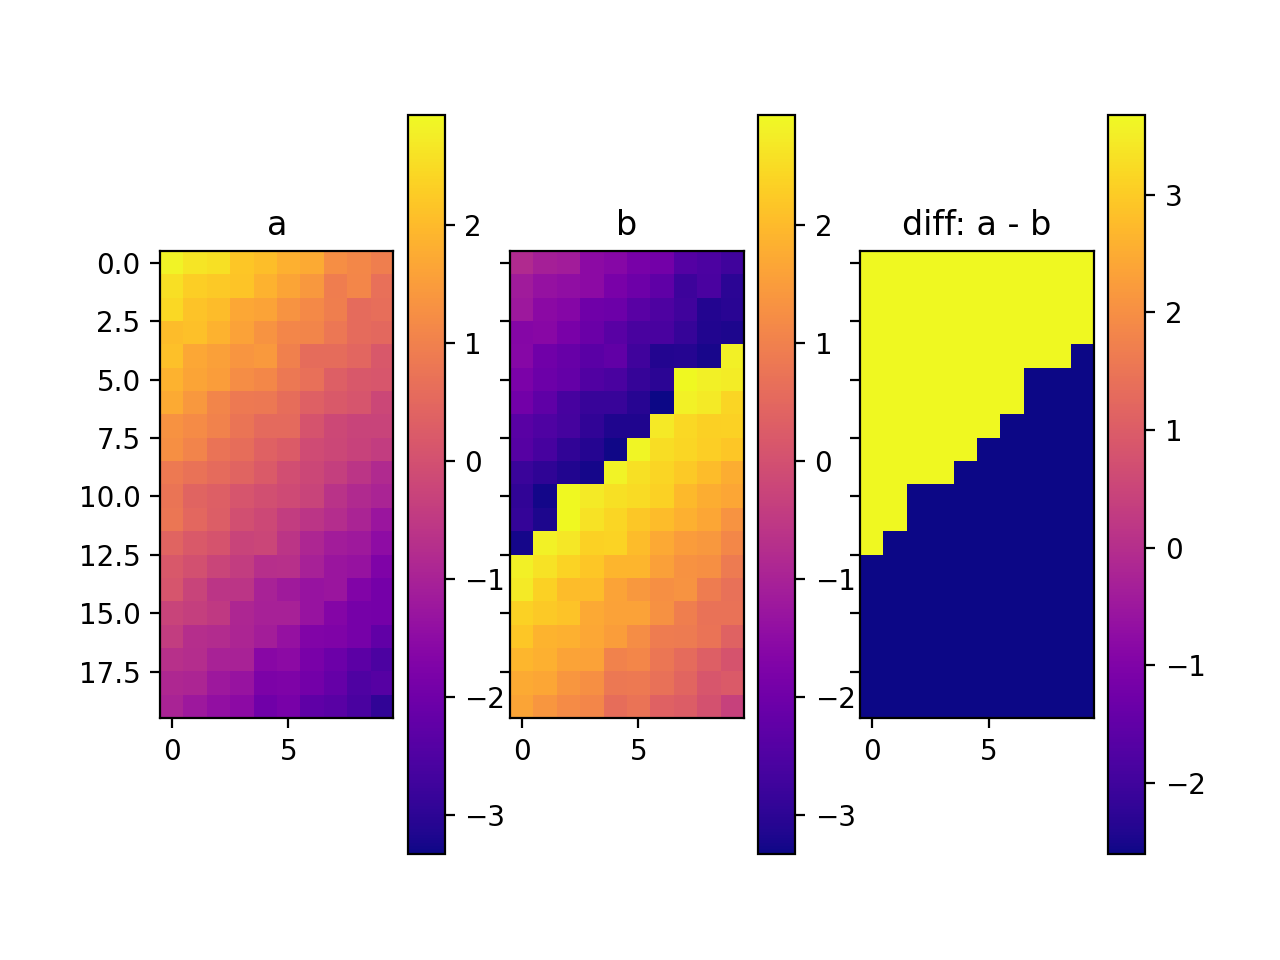

In [354]:
plot_diff(f, f_wrapped,)


In [355]:
# estimated phase gradient image: fx, fy
Dx, Dy = make_differentiation_matrices(*f_wrapped.shape, boundary_conditions='neumann')
# phi_x2, phi_y2 = est_wrapped_gradient2(f_wrapped)
phi_x, phi_y = est_wrapped_gradient(f_wrapped, Dx=Dx, Dy=Dy)
fwx, fwy = tv_regularized_gradient(f, Dx=Dx, Dy=Dy, tuning_parameter=.33, splitting_parameter=1.5e-2, 
                                 iterations=100, diagnostics=False)



<IPython.core.display.Javascript object>


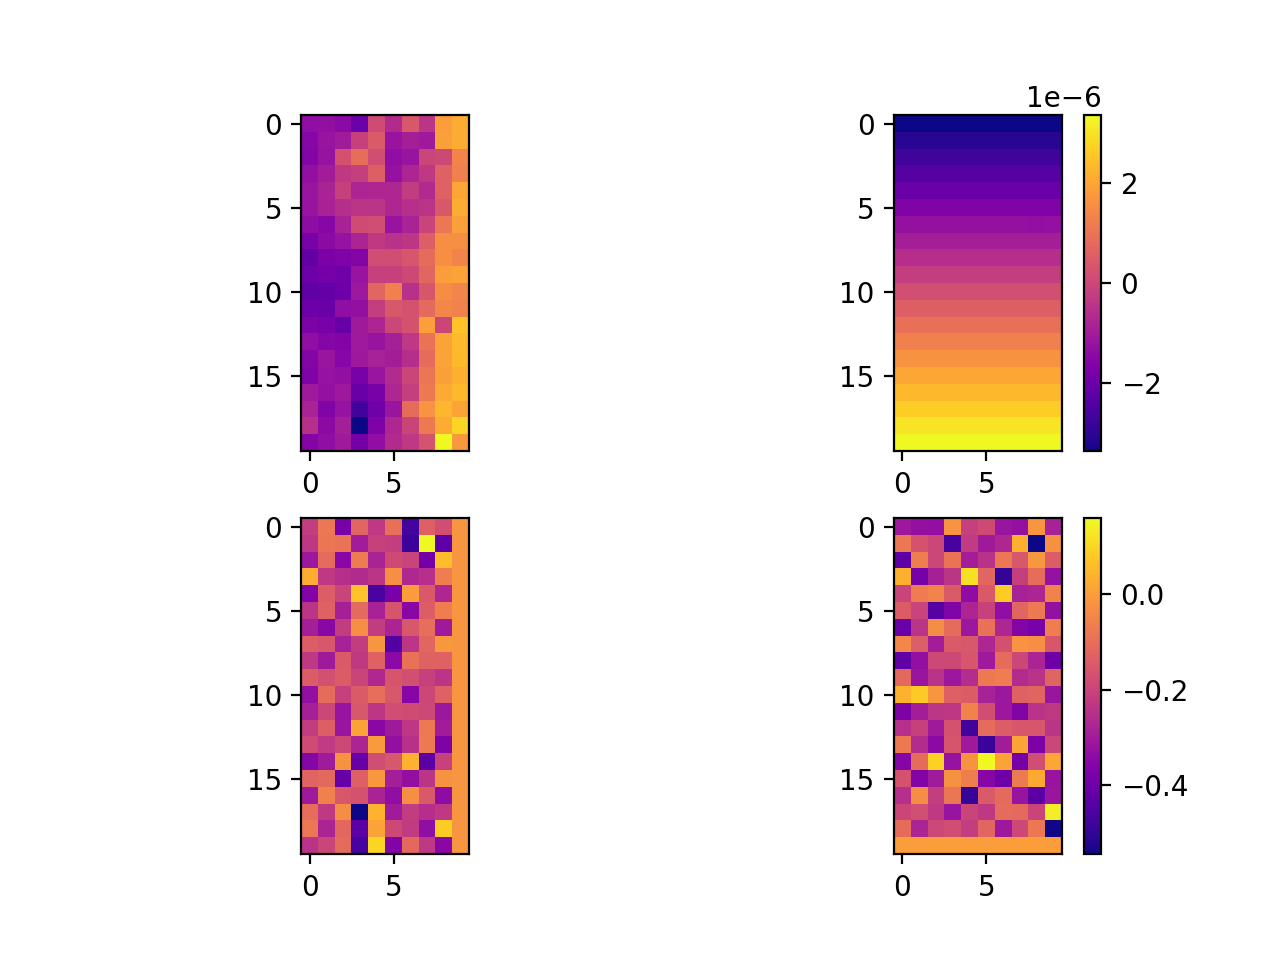

In [356]:
plt.close()
plt.figure()
plt.subplot(221)
plt.imshow(fwx, cmap='plasma')
plt.subplot(222)
plt.imshow(fwy, cmap='plasma')
plt.colorbar()

# plt.close()
# plt.figure()
plt.subplot(223)
plt.imshow(phi_x, cmap='plasma')
plt.subplot(224)
plt.imshow(phi_y, cmap='plasma')
plt.colorbar()

In [357]:
%%time
F = unwrap(f_wrapped, c=1.6, p=-.5)

Making Dx, Dy with boundary_conditions = 'neumann'
iteration = 0 with change = 2.925415443112041
iteration = 1 with change = 1.0658141036401503e-14
Finished after iteration = 1 with change = 1.0658141036401503e-14
CPU times: user 5.61 ms, sys: 1.09 ms, total: 6.7 ms
Wall time: 5.77 ms


<ipython-input-351-43e39ed9a1ba>:30: RuntimeWarning: divide by zero encountered in true_divide
  K = -np.nan_to_num(1 / eigvals, posinf=0, neginf=0)


[[2.84733196 2.63403649 2.56642546 2.1749145  2.06205134]
 [2.538485   2.308043   2.23730072 2.1555319  1.85261926]
 [2.46092639 2.14438752 2.04565087 1.68964758 1.63142972]
 [2.03518528 2.08322887 1.85449772 1.60283727 1.33831856]
 [2.07168217 1.70132625 1.56579032 1.36550502 1.45679862]]
subtracting mean


<IPython.core.display.Javascript object>


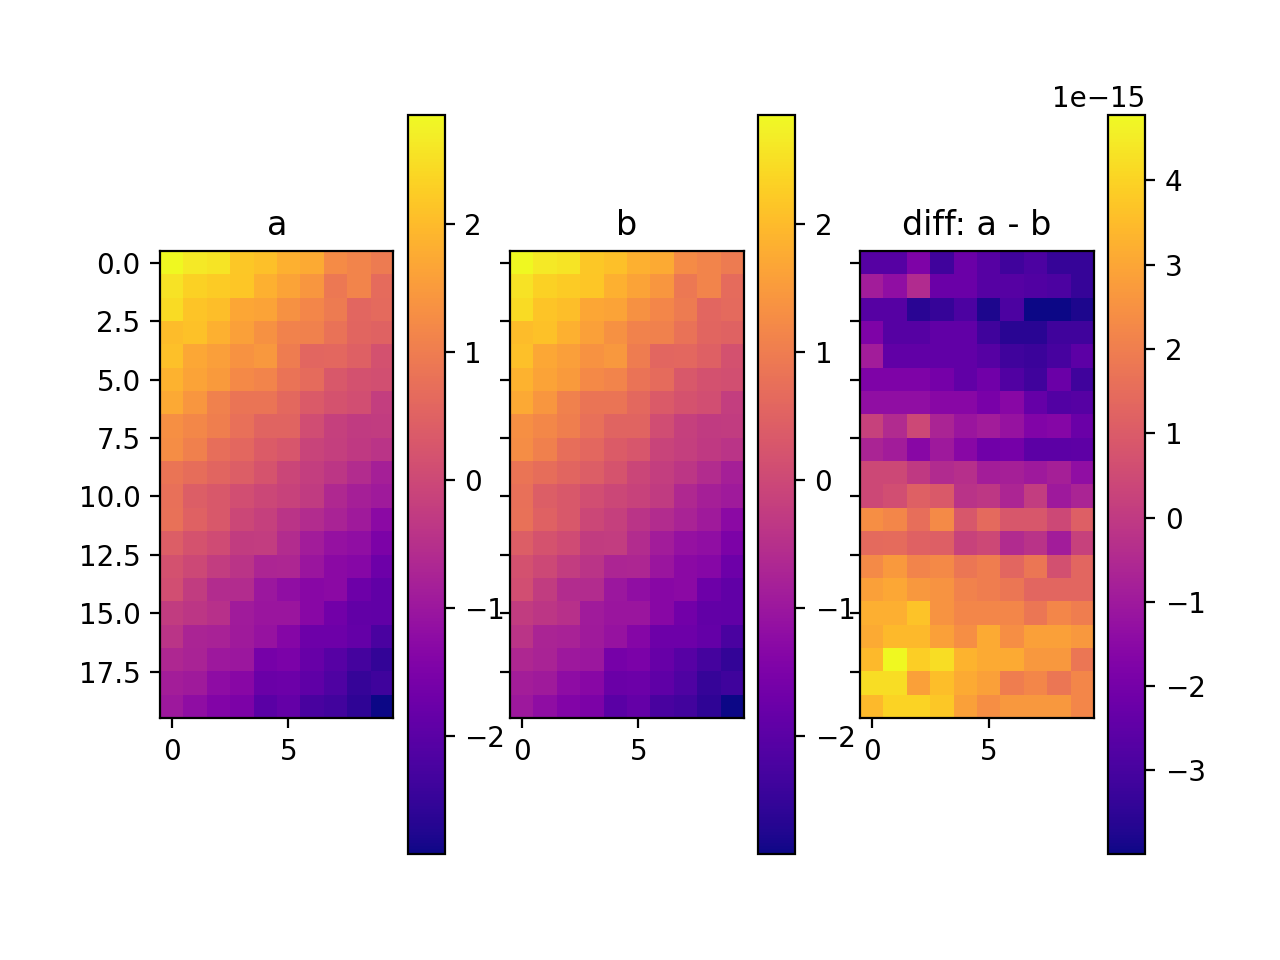

In [358]:
print(F[:5, :5])
plot_diff(F, f, zero_mean=True)

# Now a real interferogram

In [280]:
import rasterio as rio
from scipy.ndimage import gaussian_filter

with rio.open("20150328_20150409_int.tif") as src:
    igram = src.read(1)
    igram_phase = np.angle(igram)

with rio.open("20150328_20150409_unw_snaphu.tif") as src:
    unw_snaphu = src.read(2)

print(igram.dtype)
print(np.max(unw_snaphu))

complex64
13.149802


In [281]:
igram_phase.shape
# Dx1, Dy1 = make_differentiation_matrices(*igram_phase.shape)
# fx1, fy1 = tv_regularized_gradient(igram_phase, Dx=Dx1, Dy=Dy1, tuning_parameter=.33, splitting_parameter=1.5e-2, 
#                                  iterations=30, diagnostics=False)
# fx2, fy2 = est_wrapped_gradient(igram_phase, Dx1, Dy1)

(778, 947)

In [359]:
%%time
unw_sparse = unwrap(igram_phase, max_iters=100, c=1.3, p=0, lmbda=1, tol=np.pi/10)

# fx1, fy1 = tv_regularized_gradient(igram_phase,tuning_parameter=1, splitting_parameter=1, iterations=10)
# unw_sparse = unwrap(igram_phase, phi_x=fx1, phi_y=fy1,max_iters=500, c=1.6)

# unw_sparse = unwrap(gaussian_filter(igram_phase, 1), c=1.6, max_iters=100)

print(unw_sparse[:4, :4])
print(np.max(unw_sparse))
print(np.max(unw_snaphu))

Making Dx, Dy with boundary_conditions = 'neumann'


<ipython-input-351-43e39ed9a1ba>:30: RuntimeWarning: divide by zero encountered in true_divide
  K = -np.nan_to_num(1 / eigvals, posinf=0, neginf=0)


iteration = 0 with change = 10.161758806295932
iteration = 1 with change = 3.991182384542713
iteration = 2 with change = 3.9814786648314477
iteration = 3 with change = 2.64277014906739
iteration = 4 with change = 1.6412397746208751
iteration = 5 with change = 1.2306789093923185
iteration = 6 with change = 0.9795453713872124
iteration = 7 with change = 1.0546610604758886
iteration = 8 with change = 0.9334659489095758
iteration = 9 with change = 0.8221111846452893
iteration = 10 with change = 0.9406975930492649
iteration = 11 with change = 0.6369900106306607
iteration = 12 with change = 0.6500713515738035
iteration = 13 with change = 0.6477999827711818
iteration = 14 with change = 0.5604365422353594
iteration = 15 with change = 0.6023176692096568
iteration = 16 with change = 0.5943702373270838
iteration = 17 with change = 0.5589347978039672
iteration = 18 with change = 0.6623490656730775
iteration = 19 with change = 0.649158617287442
iteration = 20 with change = 0.6597570564156592
iterat

4783339.9548761835


<IPython.core.display.Javascript object>


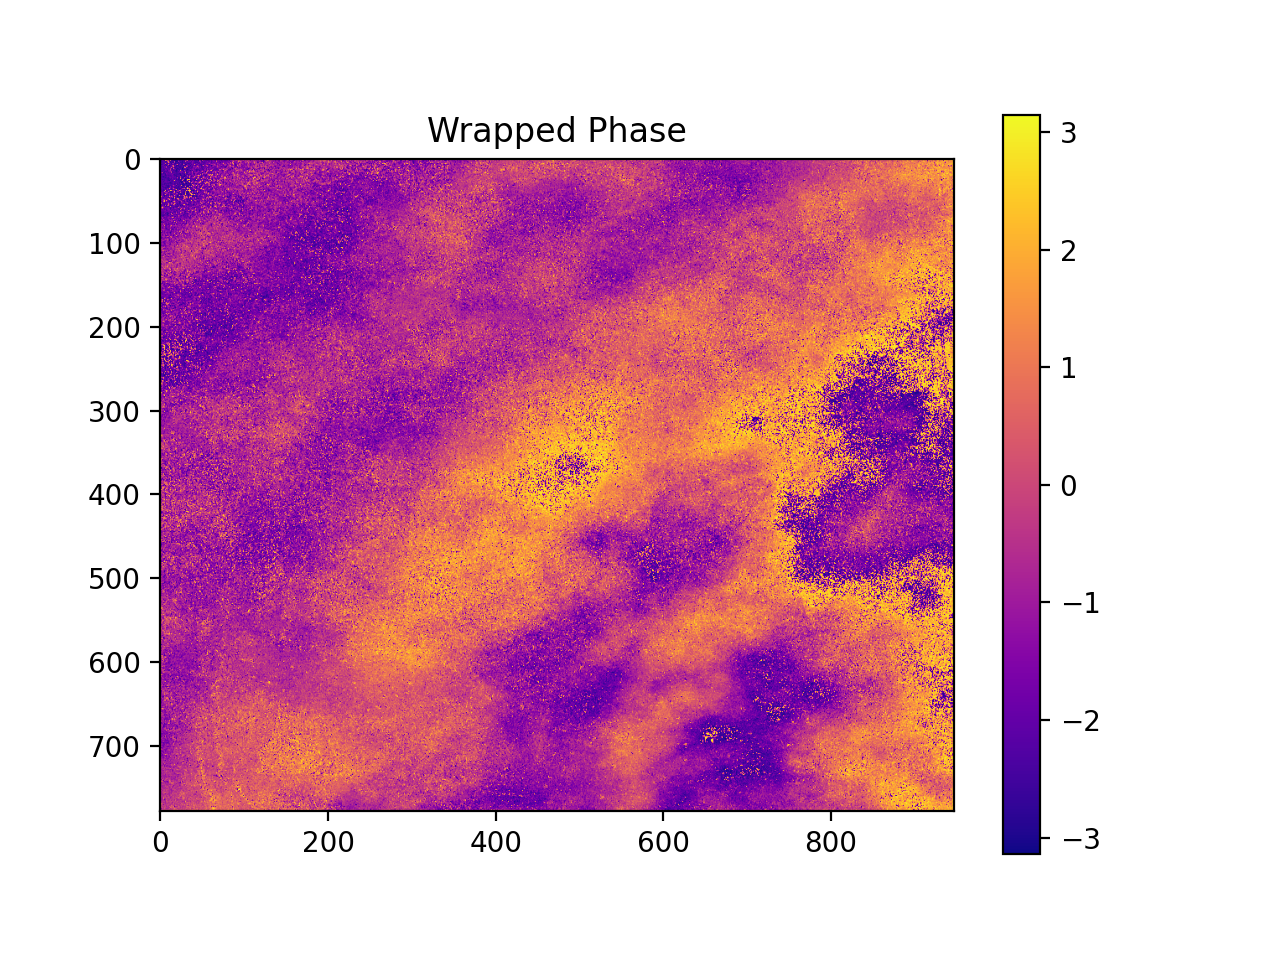

<IPython.core.display.Javascript object>


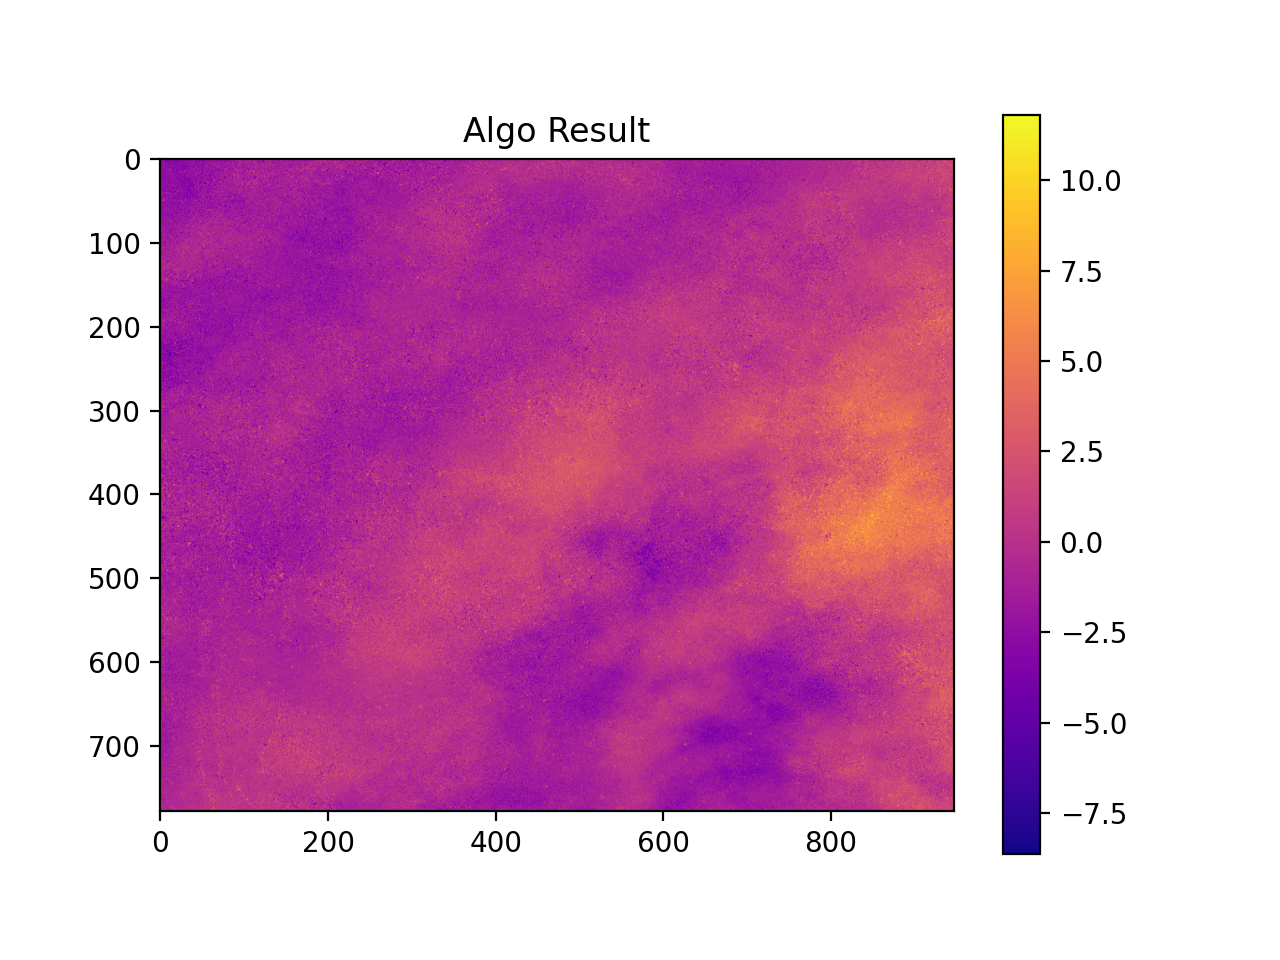

subtracting mean


<IPython.core.display.Javascript object>


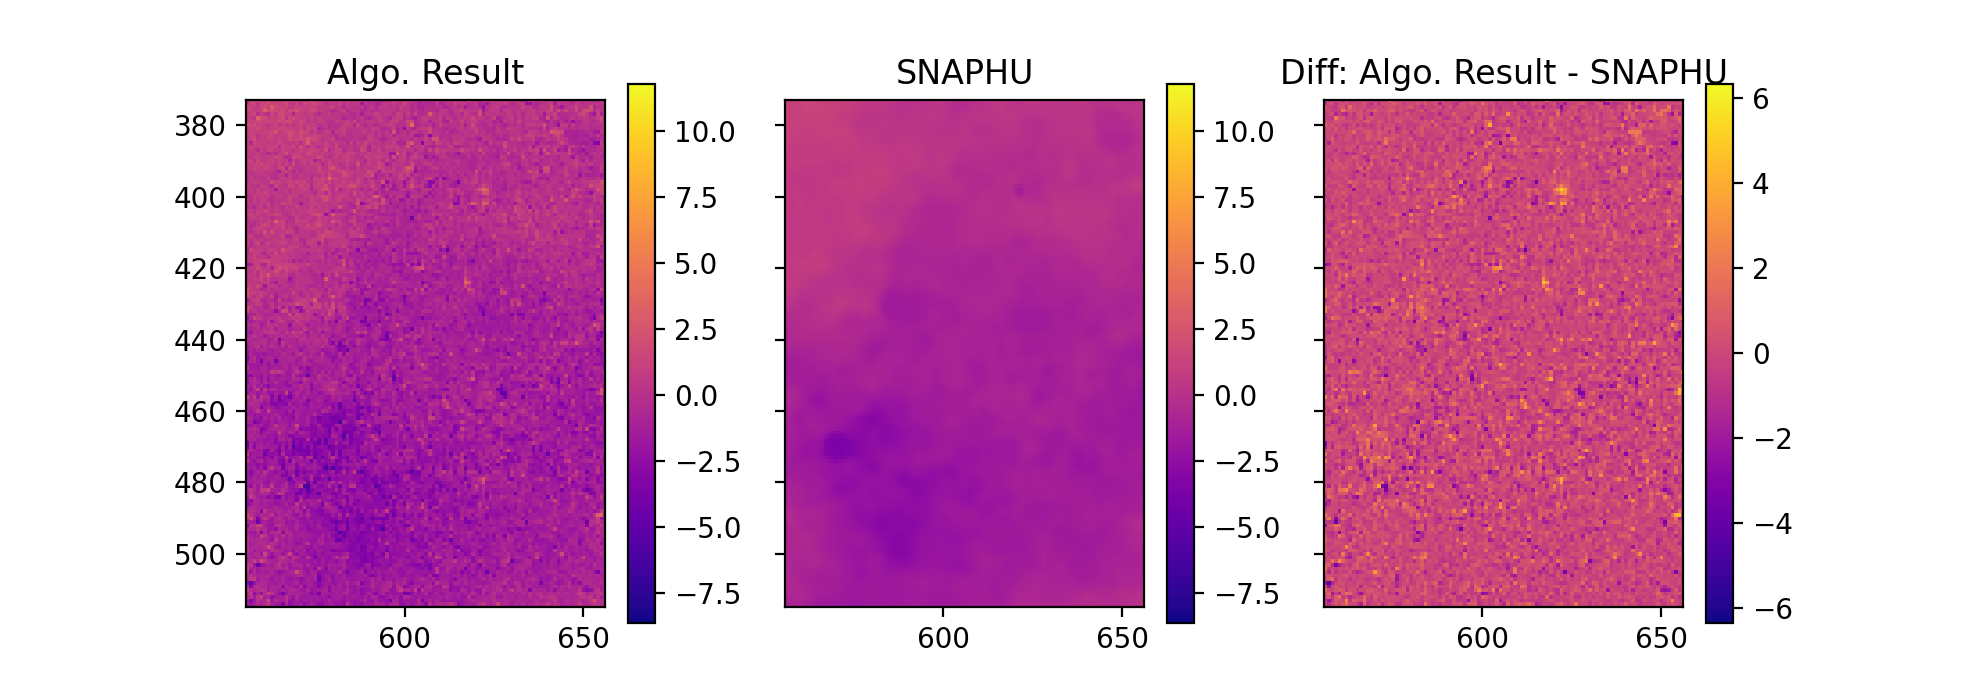

In [360]:
print(np.sum(np.abs(unw_sparse - unw_snaphu)))
plt.close()
plt.figure()
plt.imshow(igram_phase, cmap='plasma')
plt.colorbar()
plt.title("Wrapped Phase")

# plt.close()
plt.figure()
plt.imshow(unw_sparse, cmap='plasma')
plt.colorbar()
plt.title("Algo Result")


plot_diff(unw_sparse, 
          unw_snaphu,
          zero_mean=True,
          titles=["Algo. Result", "SNAPHU"])



4783342.831298413


<IPython.core.display.Javascript object>


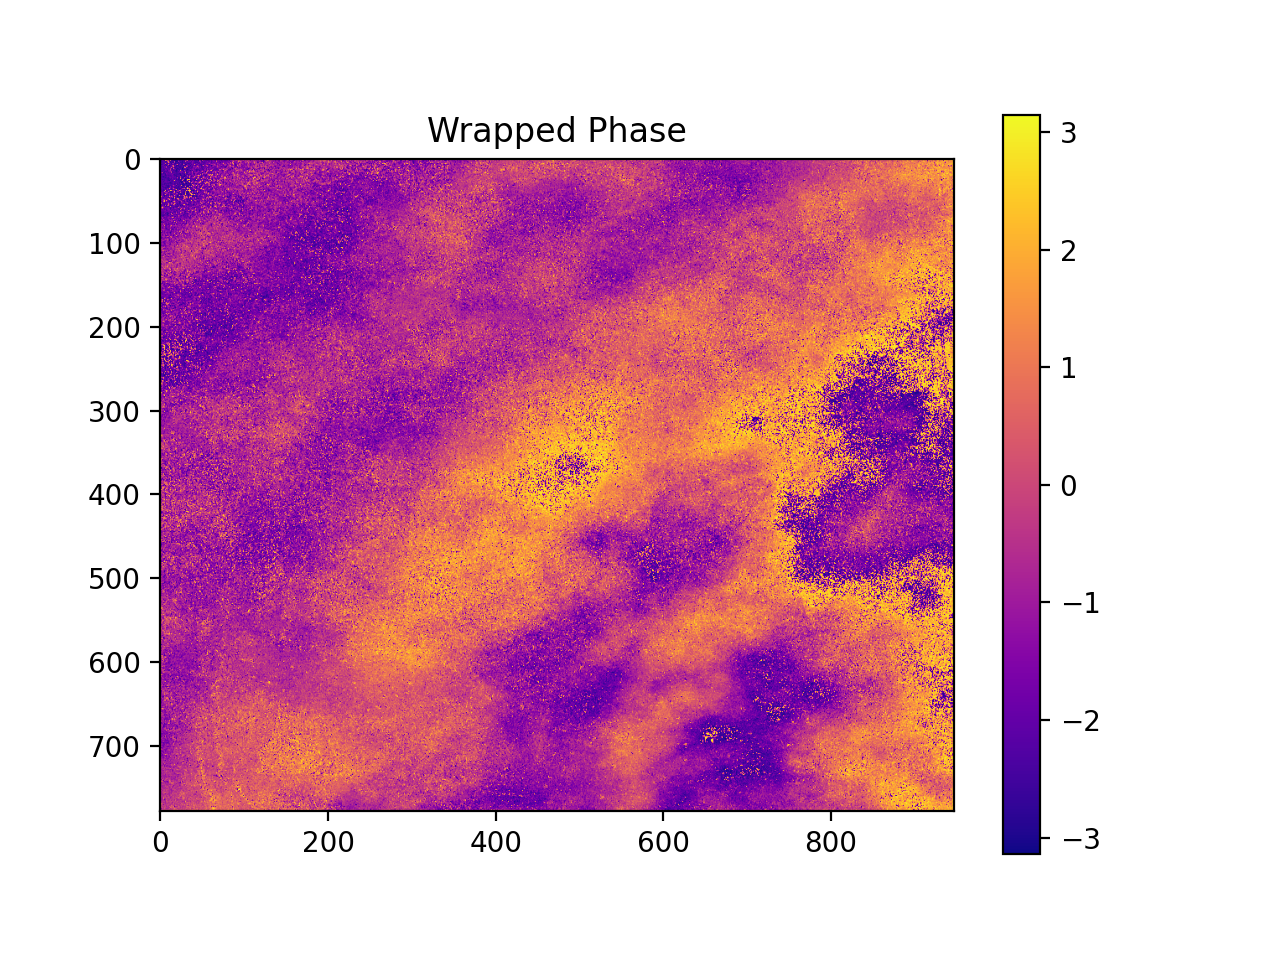

<IPython.core.display.Javascript object>


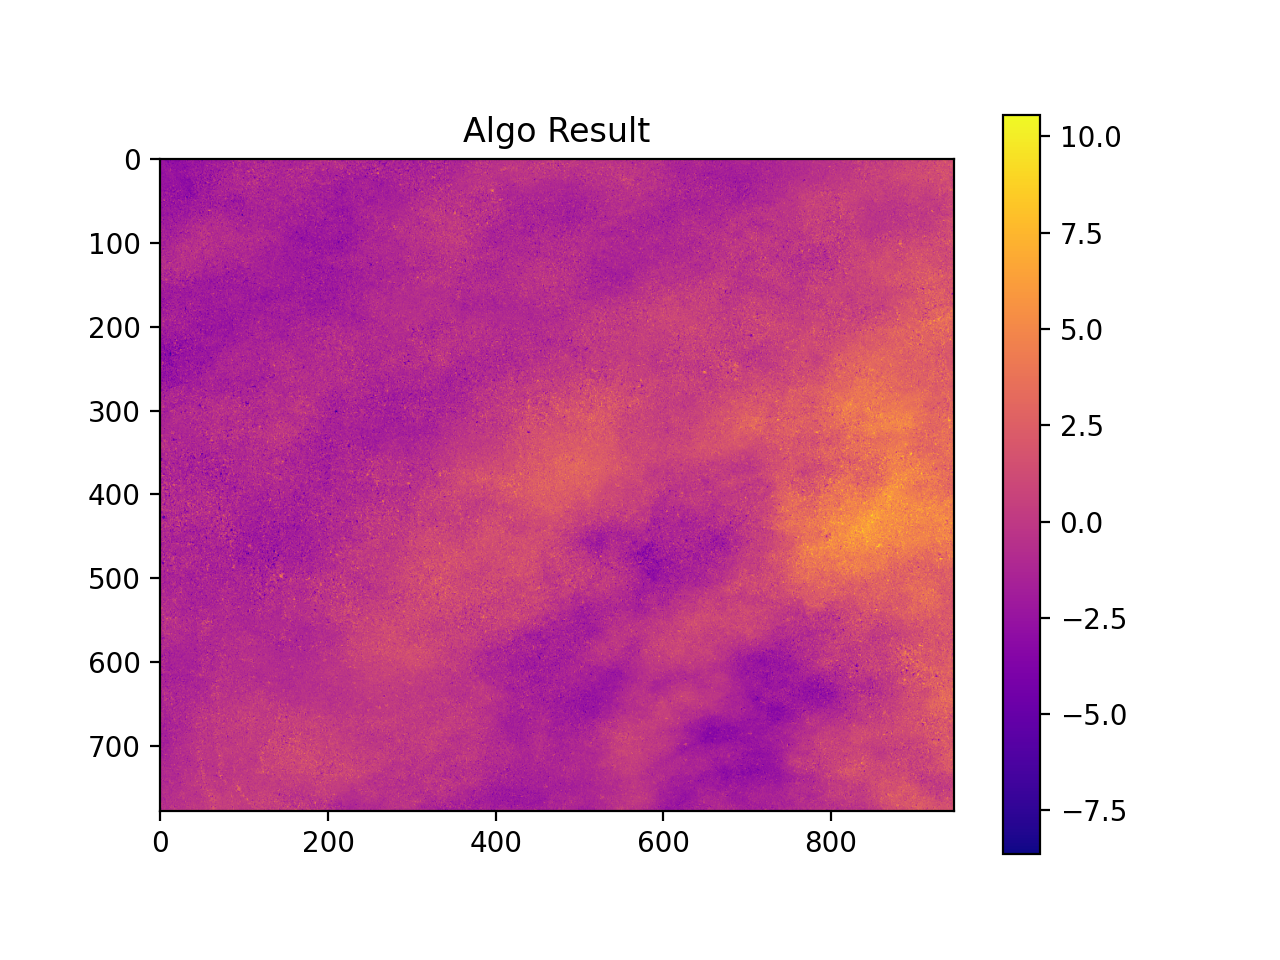

subtracting mean


<IPython.core.display.Javascript object>


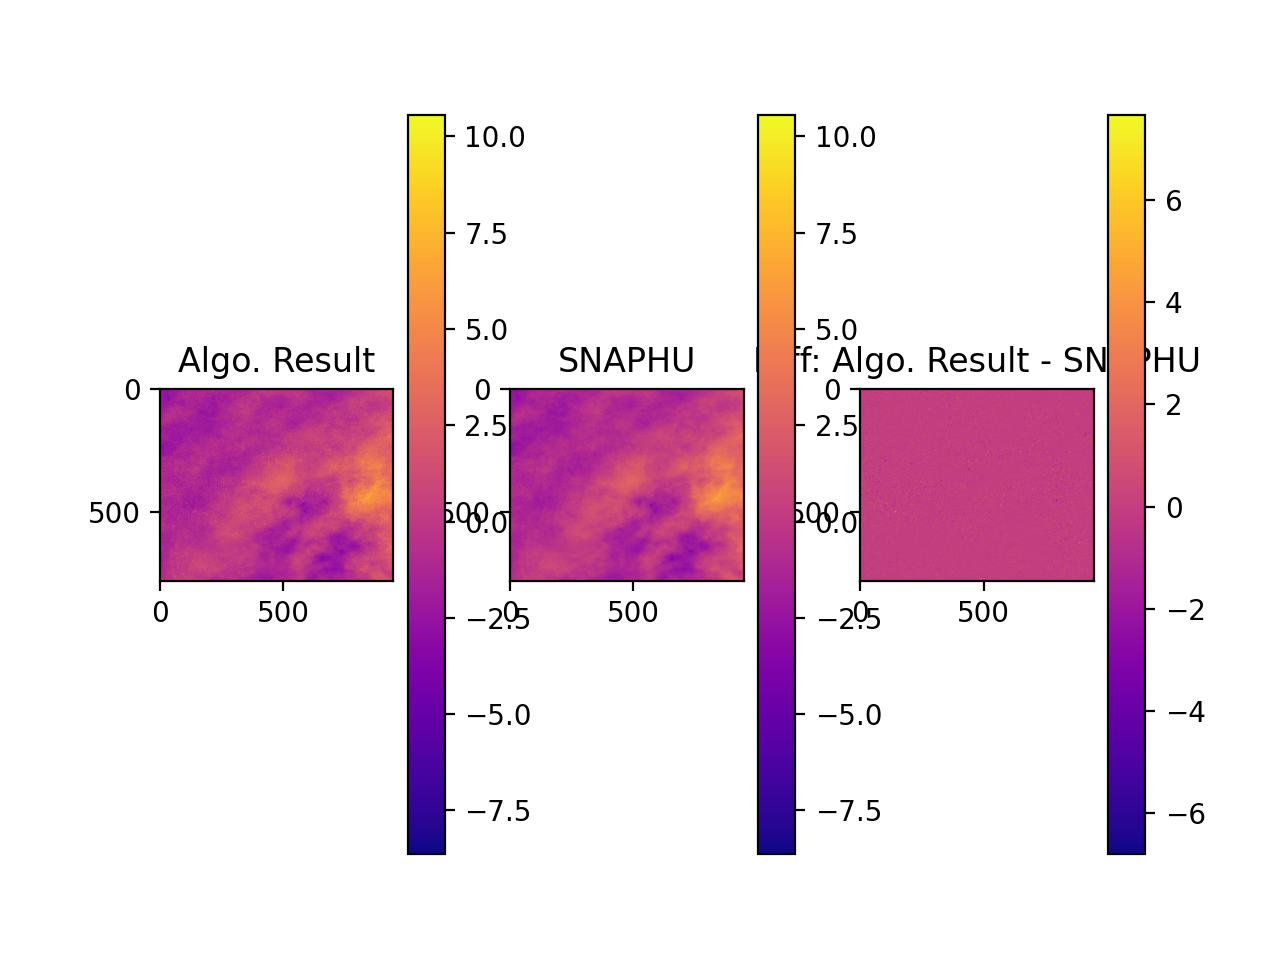

In [293]:
print(np.sum(np.abs(unw_sparse - unw_snaphu)))
plt.close()
plt.figure()
plt.imshow(igram_phase, cmap='plasma')
plt.colorbar()
plt.title("Wrapped Phase")

plt.figure()
plt.imshow(unw_sparse, cmap='plasma')
plt.colorbar()
plt.title("Algo Result")


plot_diff(unw_sparse, 
          unw_snaphu,
          zero_mean=True,
          titles=["Algo. Result", "SNAPHU"])



# Checking on differentiation matrices with different BCs

<IPython.core.display.Javascript object>


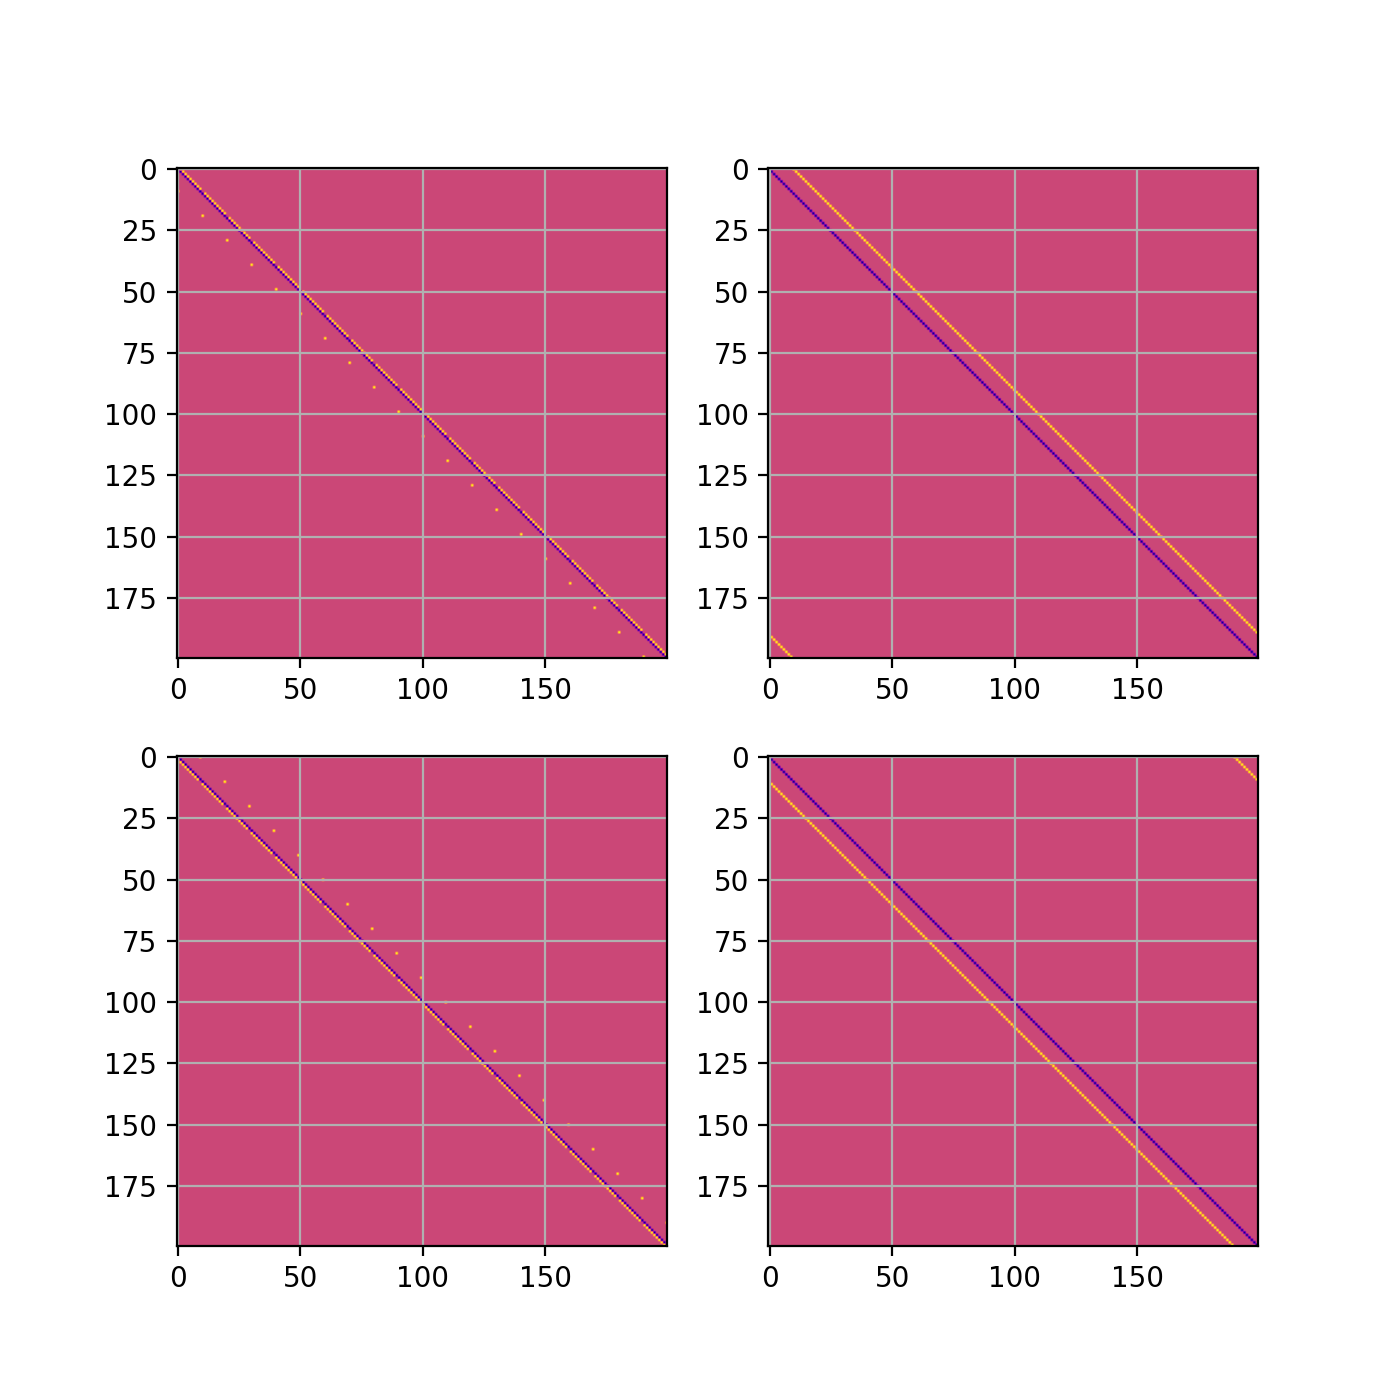

In [34]:
# rt, ct = 4, 4
rt, ct = f_wrapped.shape
dx, dy = make_differentiation_matrices(rt, ct, boundary_conditions='periodic')
dx = dx.toarray()
dy = dy.toarray()
plt.close()
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(dx, cmap='plasma')
plt.grid(True)

# plt.figure()
plt.subplot(222)
plt.imshow(dy, cmap='plasma')
plt.grid(True)

plt.subplot(223)
plt.imshow(dx.T, cmap='plasma')
plt.grid(True)

plt.subplot(224)
plt.imshow(dy.T, cmap='plasma')
plt.grid(True)

<IPython.core.display.Javascript object>


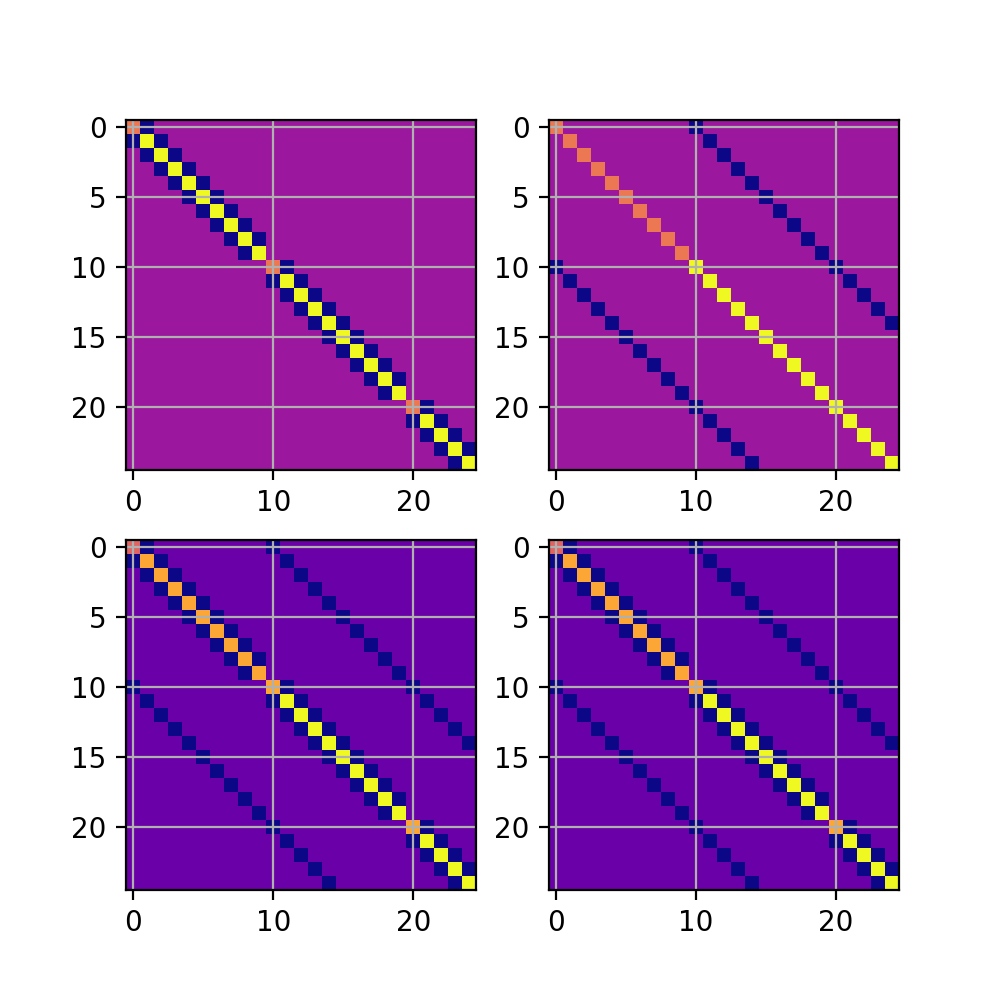

(400, 200)


In [271]:
try:
    dxd = dx.todense()
    dyd = dy.todense()
except:
    dxd = dx
    dyd = dy
    
plt.close()
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axr = axes.ravel()
# plt.subplot(221)
axr[0].imshow((dxd.T @ dxd)[:25, :25], cmap='plasma')
axr[0].grid(True)

# plt.subplot(223)
axr[1].imshow((dyd.T @ dyd)[:25, :25], cmap='plasma')
axr[1].grid(True)

DD = np.vstack((dxd, dyd))
print(DD.shape)
# plt.subplot(223)
axr[2].imshow((DD.T @ DD)[:25, :25], cmap='plasma')
axr[2].grid(True)

axr[3].imshow((dxd.T @ dxd + dyd.T @ dyd)[:25, :25], cmap='plasma')
axr[3].grid(True)

<ipython-input-11-6ec3914dacb7>:30: RuntimeWarning: divide by zero encountered in true_divide
  K = np.nan_to_num(1 / eigvals, posinf=0, neginf=0)
<ipython-input-40-d1f25f632e8b>:2: RuntimeWarning: divide by zero encountered in true_divide
  Kinv = np.nan_to_num(1/K, posinf=0)


<IPython.core.display.Javascript object>


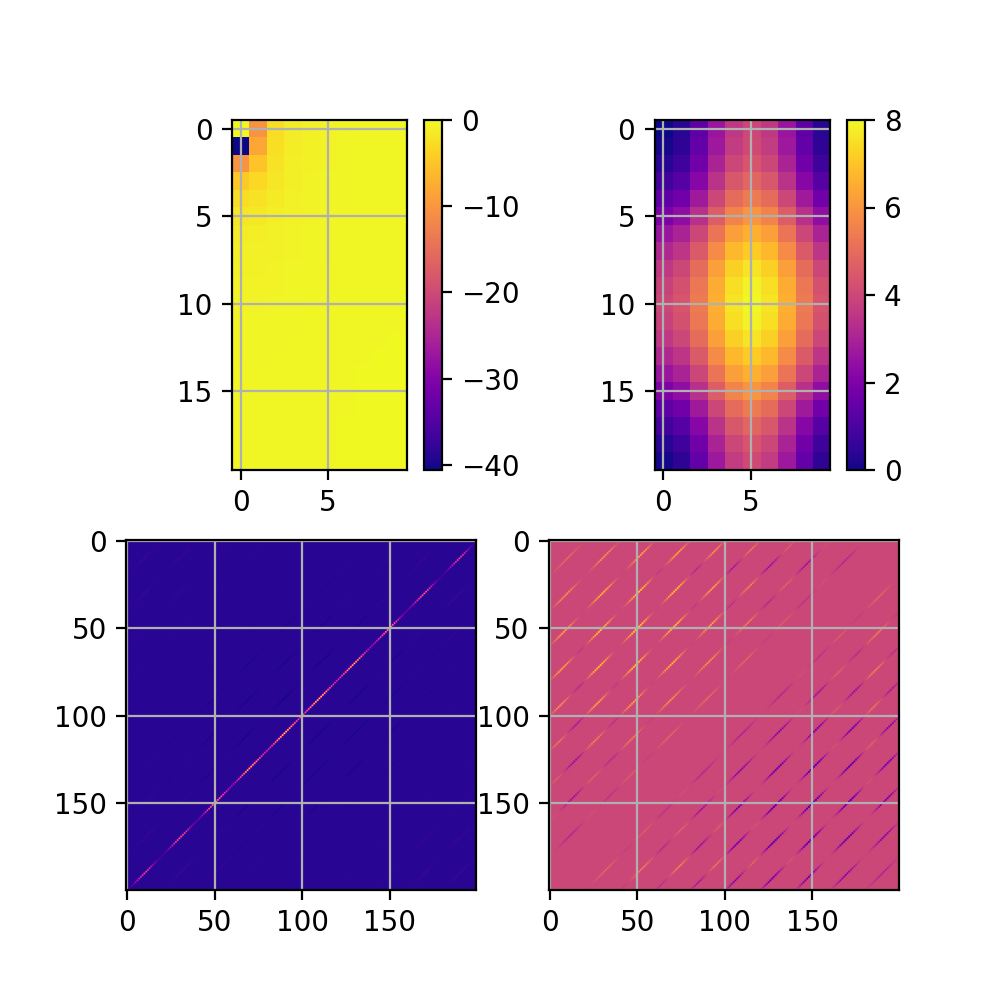

In [40]:
K = make_laplace_kernel(rt, ct)
Kinv = np.nan_to_num(1/K, posinf=0)

# EQ 17, Chartrand 2018
xi_y = (np.exp(-1j*2*np.pi/rt * np.arange(rt)) - 1).reshape((-1, 1)) # the 'k' index
xi_x = (np.exp(-1j*2*np.pi/ct * np.arange(ct)) - 1).reshape((1, -1)) # the 'l' index
# Phat = (xi_x * p_x_hat +  xi_y * p_y_hat) / (np.abs(xi_y)**2 + np.abs(xi_x)**2)
# Phat[0, 0] = 0
Laplace_hat = (np.abs(xi_y)**2 + np.abs(xi_x)**2)


plt.close()
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axr = axes.ravel()

axim=axr[0].imshow(K, cmap='plasma')
axr[0].grid(True)
fig.colorbar(axim, ax=axr[0])

axim=axr[1].imshow(Laplace_hat, cmap='plasma')
axr[1].grid(True)
fig.colorbar(axim, ax=axr[1])

LL = dx.T @ dx + dy.T @ dy
axr[2].imshow(fft2(LL).real, cmap='plasma')
axr[2].grid(True)

axr[3].imshow(fft2(LL).imag, cmap='plasma')
axr[3].grid(True)


In [41]:
import scipy.fft
from scipy.sparse.linalg import spsolve, lsqr
obj = dx.T @ dx + dy.T @ dy
print(obj.shape, type(obj))
# scipy.fft.fft2(obj)
# W, V = LA.eig(dx.T @ dx)
# print(W)
# print(LA.eig(dx)[0])

(200, 200) <class 'numpy.ndarray'>


# TESTING LAPLACE KERNEL: solving exactly

In [250]:
bc = 'dirichlet'
dx, dy = make_differentiation_matrices(*f_wrapped.shape, boundary_conditions=bc)
fx, fy = est_wrapped_gradient(f_wrapped, dx, dy)
phi = np.stack(est_wrapped_gradient(f_wrapped, dx, dy), axis=0)
phi_true = np.stack(est_wrapped_gradient(f, dx, dy), axis=0)

# # Try padding array for bounds? does not seem to work
# f_wrapped_pad = np.pad(f_wrapped, 1, mode='reflect')
# f_pad = np.pad(f, 1, mode='reflect')
# dx, dy = make_differentiation_matrices(*f_wrapped_pad.shape, boundary_conditions='neumann')
# phi = np.stack(est_wrapped_gradient(f_wrapped_pad, dx, dy), axis=0)
# phi_true = np.stack(est_wrapped_gradient(f_pad, dx, dy), axis=0)
_, r, c = phi.shape
phi.shape

(2, 20, 10)

<IPython.core.display.Javascript object>


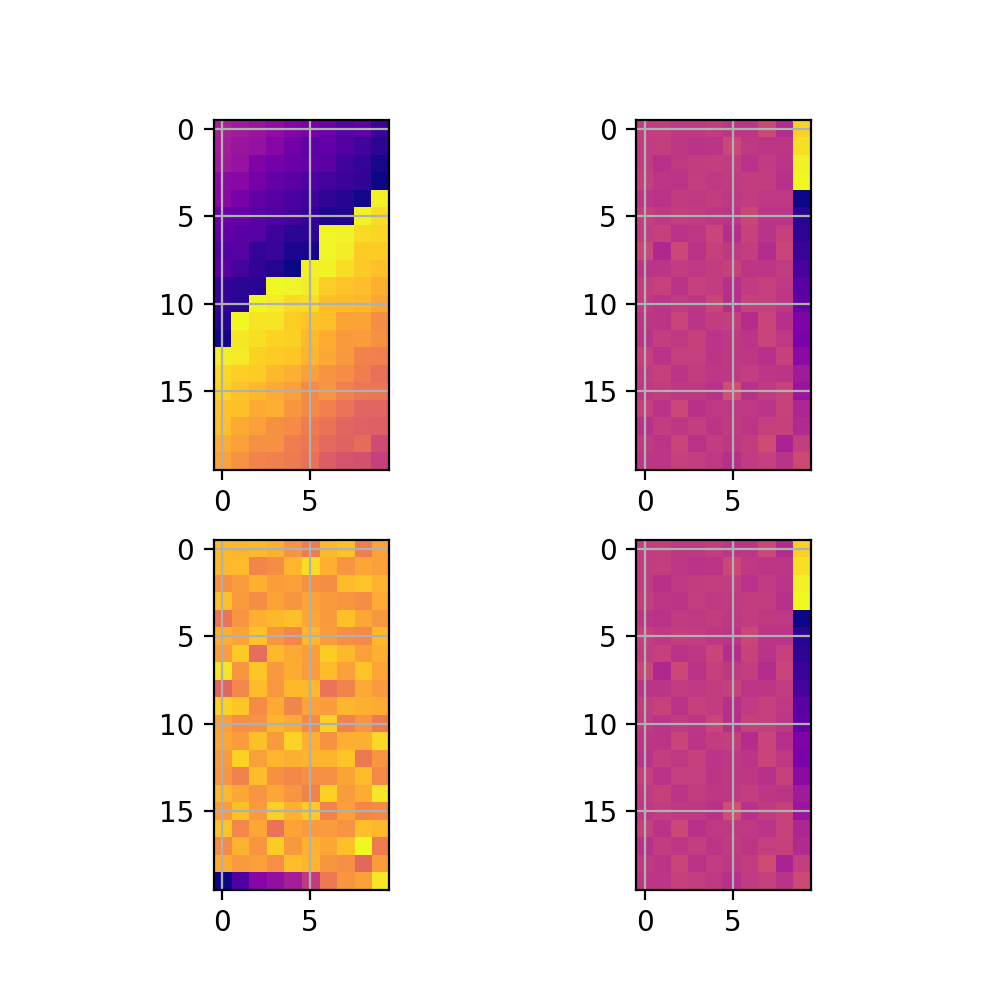

(2, 1)


In [251]:

plt.close()
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axr = axes.ravel()
# plt.subplot(221)
axr[0].imshow(f_wrapped, cmap='plasma')
axr[0].grid(True)

# plt.subplot(223)
axr[1].imshow(phi[0], cmap='plasma')
axr[1].grid(True)

DD = np.vstack((dx, dy))
print(DD.shape)
# plt.subplot(223)
axr[2].imshow(phi[1], cmap='plasma')
axr[2].grid(True)

axr[3].imshow(phi_true[0], cmap='plasma')
axr[3].grid(True)



In [252]:
def cost(Phi_vec, phi, Dx, Dy):
    _, r, c = phi.shape
    DF = np.stack(est_wrapped_gradient(Phi_vec.reshape(r, c), Dx, Dy), axis=0)
    return np.sum((DF - phi)**2)
#     return np.sum(np.abs(DF - phi))
#     return np.sum((DF[:, :-1, :-1] - phi[:, :-1, :-1])**2)
# NOTE: with "periodic", the bad right boundary of the gradient seems to mess up the squared cost...


In [253]:
%%time

P0vec = f_wrapped.ravel()/10
bounds = np.zeros((len(P0vec), 2))
bounds[:, 0] = np.min(f) - 1; bounds[:, 1] = np.max(f) + 1
# print(len(P0vec), len(bounds))
# soln = optimize.minimize(lambda P: cost(P, phi), P0vec, bounds=bounds)
soln = optimize.minimize(lambda P: cost(P, phi_true, dx, dy), P0vec, bounds=bounds)
# print(soln)
Phi_hat = soln.x.reshape(r, c)

CPU times: user 853 ms, sys: 13 ms, total: 866 ms
Wall time: 908 ms


In [254]:
# Pvec = np.ones_like(phi[0].ravel())
# Pvec = f_wrapped/10

# print(np.stack(est_wrapped_gradient(Pvec.reshape(r, c)), axis=0))
# print(phi[0][:4, :4])
# print(est_wrapped_gradient(Phi_hat)[0][:4, :4])
# print(cost(Phi_hat.ravel()*1, phi, dx, dy))


subtracting mean


<IPython.core.display.Javascript object>


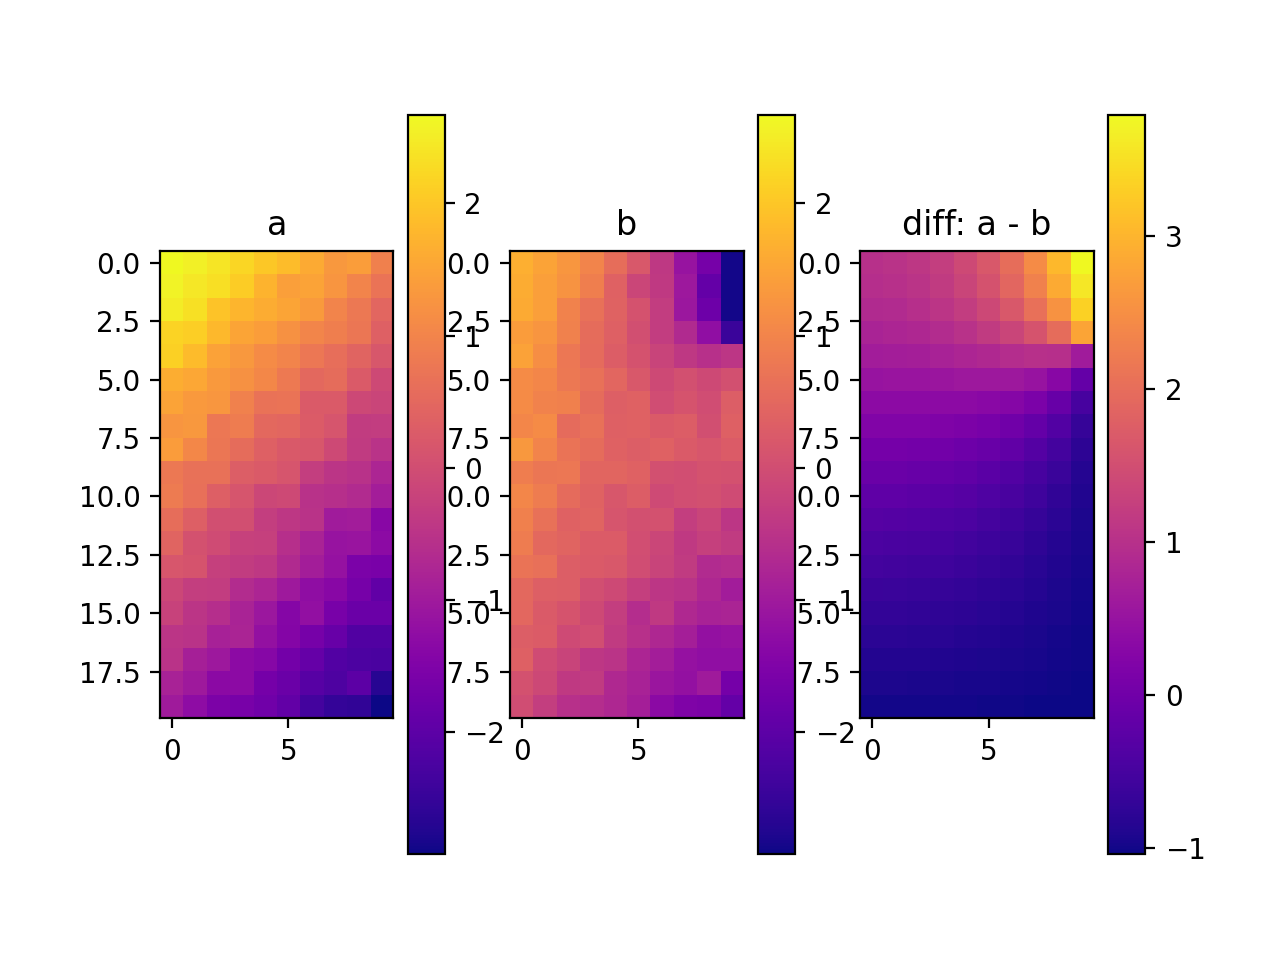

In [255]:
# plot_diff(f_wrapped, Phi_hat)
plot_diff(f, Phi_hat)

In [268]:
%%time 

from numpy import pi, cos

# Solving (5) is equivalent to solving the following linear equation...
r, c = phi[0].shape
rhs = dx.T @ phi[0].ravel() + dy.T @ phi[1].ravel()
# rhs = dx.T @ phi_true[0].ravel() + dy.T @ phi_true[1].ravel()
K2 = dx.T @ dx + dy.T @ dy

# rhs_hat = dctn(rhs.reshape(r, c)).reshape(-1)
# rhs_hat = dct(rhs)
# K_hat = dctn(K2.todense())
# Phi2 = idct(rhs_hat).reshape(r, c)

if bc =='neumann':
    # Numerical recipes, Section 20.4.1, Eq. 20.4.22 is the Neumann case
    # or https://elonen.iki.fi/code/misc-notes/neumann-cosine/
    xi_y = (2*cos(pi * np.arange(r)/r) - 2).reshape((-1, 1))
    xi_x = (2*cos(pi * np.arange(c)/c) - 2).reshape((1, -1))
    denom = xi_y + xi_x + 1e-6
    denom_inv = -np.nan_to_num(1 / denom, posinf=0, neginf=0)

    t = 2
    # factor = r*c/4 # ?
    factor = 1
    rho_hat = dctn(rhs.reshape(r, c), norm='ortho', type=2) # times delta**2 ?
    Phi2 = idctn(factor * rho_hat * denom_inv, norm='ortho', type=2)
elif bc == 'periodic':
    # Numerical recipes, Section 20.4.1, Eq. 20.4.4 for periodic
    # Note: almost same, but 2pi in cosine instead of pi
    xi_y = (2*cos(2*pi * np.arange(r)/r) - 2).reshape((-1, 1))
    xi_x = (2*cos(2*pi * np.arange(c)/c) - 2).reshape((1, -1))
    denom = xi_y + xi_x + 1e-6
    denom_inv = np.nan_to_num(1 / denom, posinf=0, neginf=0)

    t = 2
    # factor = r*c/4 # ?
    factor = 1
    rho_hat = fft2(rhs.reshape(r, c), norm='ortho').real
    Phi2 = ifft2(factor * rho_hat * denom_inv, norm='ortho').real
elif bc == 'dirichlet':
    # Note this doesnt work...
    from scipy.fft import dstn, idstn
    # Numerical recipes, Section 20.4.1, Eq. 20.4.10 for dirichlet
    xi_y = (2 - 2*cos(pi * np.arange(r)/r)).reshape((-1, 1))
    xi_x = (2 - 2*cos(pi * np.arange(c)/c)).reshape((1, -1))
    denom = xi_y + xi_x + 1e-6
    denom_inv = -np.nan_to_num(1 / denom, posinf=0, neginf=0)

    t = 2
    rho_hat = dstn(rhs.reshape(r, c), norm='ortho', type=t) # times delta**2 ?
    Phi2 = idstn(rho_hat * denom_inv, norm='ortho', type=t)


# def abs2(x): return np.abs(x)**2
# xi_y = abs2(np.exp(1j*2*np.pi/r * np.arange(r)) - 1).reshape((-1, 1)) # the 'k' index
# xi_x = abs2(np.exp(1j*2*np.pi/c * np.arange(c)) - 1).reshape((1, -1)) # the 'l' index
# denom = xi_y + xi_x
# rhs_hat = fft2(rhs.reshape(r, c))
# Phi2 = ifft2(np.nan_to_num(rhs_hat / denom, posinf=0, neginf=0)).real[::-1]

# rho_hat = rfft2(rhs.reshape(r, c)) # times delta**2 ?
# Phi2 = ifft2(r*c/4*rho_hat / denom).real


# # WITHOUT any transforms: using linear solver
# Phi2 = LA.lstsq(K2, rhs, rcond=None)[0].reshape(phi[0].shape)

# DD = sp.vstack((dx, dy))
# b = np.hstack((phi_true[0].ravel(), phi_true[1].ravel()))
# print(DD.shape, b.shape)
# Phi2 = LA.lstsq(DD.toarray(), b, rcond=None)[0].reshape(f_wrapped.shape)
# Phi2 = lsqr(DD, b)[0].reshape(f_wrapped.shape)

# # EQ 17, Chartrand 2018
# p_x_hat = fft2(phi[0])
# p_y_hat = fft2(phi[1])
# xi_y = (np.exp(-1j*2*np.pi/r * np.arange(r)) - 1).reshape((-1, 1)) # the 'k' index
# xi_x = (np.exp(-1j*2*np.pi/c * np.arange(c)) - 1).reshape((1, -1)) # the 'l' index
# Phat = (xi_x * p_x_hat +  xi_y * p_y_hat) / (np.abs(xi_y)**2 + np.abs(xi_x)**2)
# Phat[0, 0] = 0
# print(xi_y[:3, :3])
# # print(Phat[:4, :4])
# Phi2 = ifft2(Phat).real

# print(rhs.shape, K2.shape, Kinv.shape)
# print(Phat.shape)


# rhs_hat = rfft2(rhs.reshape(r, c))
# print(rhs_hat.shape)
# Phi2 = irfft2(Kinv * rhs_hat , s=(r, c))

# Phi2 = ifft2(fft2(rhs) / fft2(K2))
# print(phi_true[0][:4, :4])
print(Phi2[:4, :4])

Phi2.shape

[[  -758.41414449  -2200.87941403  -3427.90651223  -4319.33492664]
 [ -2256.46391658  -6548.29378457 -10199.13264859 -12851.45786999]
 [ -3698.94706529 -10734.46167229 -16718.81903349 -21066.85590591]
 [ -5050.1819982  -14656.11063869 -22827.09705882 -28763.63181319]]
CPU times: user 2.7 ms, sys: 1.06 ms, total: 3.76 ms
Wall time: 3.9 ms


(20, 10)

In [269]:
# spsolve?
# dctn?
# print(type(K2))
# print(rhs.shape)
# np.nan_to_num(rhs_hat / denom, posinf=0)
# print(np.unique(np.sum(K2, axis=1)))

subtracting mean


<IPython.core.display.Javascript object>


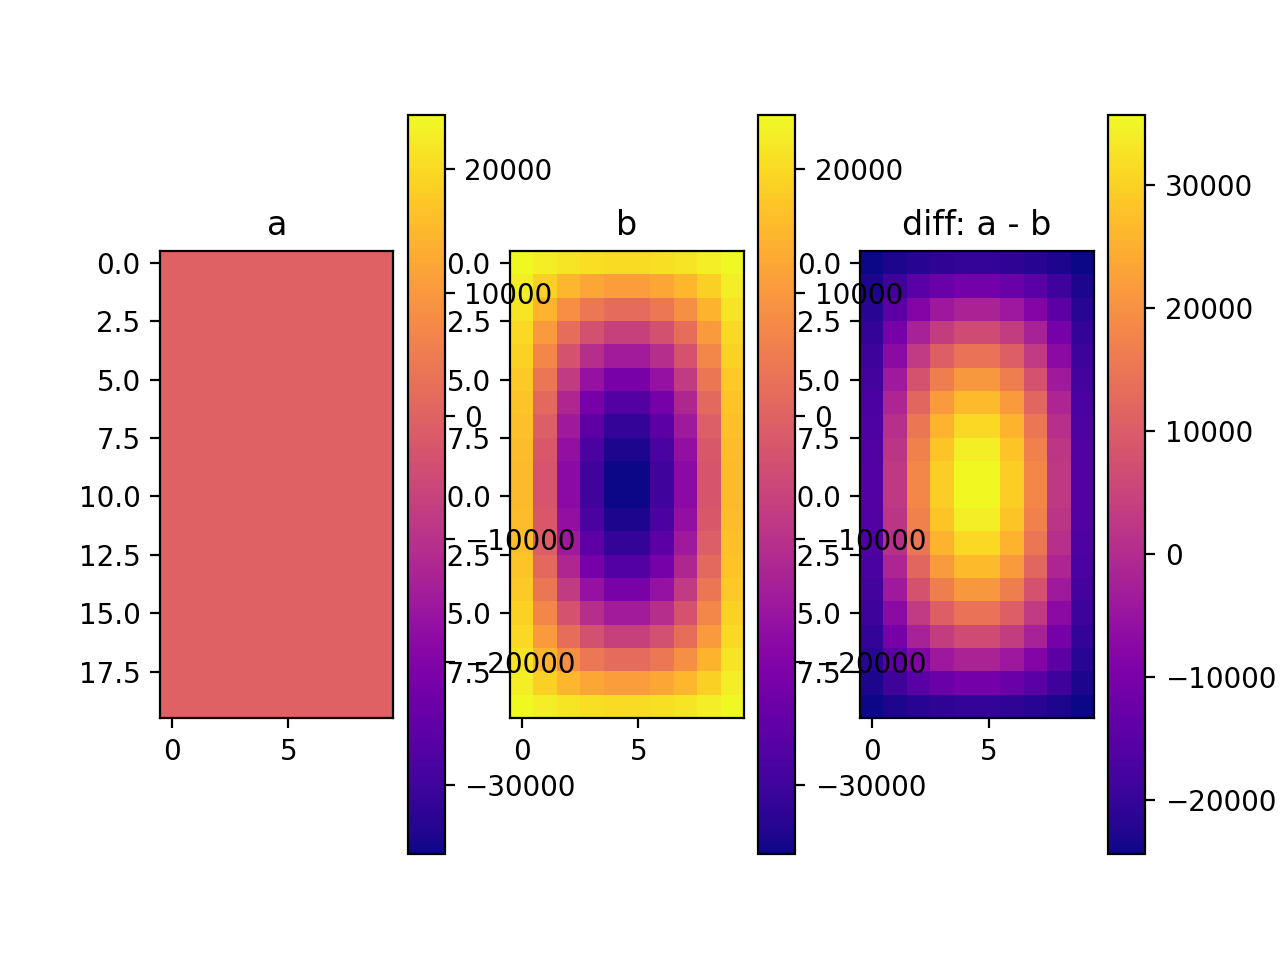

In [270]:
# TODO:
# try and do the EIG of the big dx.t dx + dy.T * dy, and see if it comes out with the same.... as analytics

plot_diff(f, Phi2)

# plt.close()
# plt.figure()
# plt.imshow(f / Phi2)

In [ ]:
print(dy.shape)
sp.vstack((dx, dy)).shape


# OTHER tests: plotting shrinkage function, etc.

In [ ]:
def S(x, lam): return np.maximum(0, (np.abs(x) - lam)) * x / np.abs(x)

plt.close()
plt.figure()
xx = np.linspace(-2, 2); lam=1.5
plt.plot(xx, S(xx, lam))

In [ ]:
# dx, dy = make_differentiation_matrices(4, 3)
# print(dx.ndim)
# print((dx.toarray() * np.arange(12)))
# print(make_differentiation_matrices(4, 3)[0] * np.arange(12))

In [ ]:
def norm1(x): return np.sum(np.abs(x))
def norm2_2(x): return np.linalg.norm(x)**2

def w_min(w, x, lam): return np.abs(w) + 1/(2*lam) * (w - x)**2

x = 2
lam=1.5
plt.close()
plt.figure()
ww = np.linspace(-4, 4, 1000);
plt.plot(ww, w_min(ww, x, lam))
print(ww[np.argmin(w_min(ww, x, lam))])
print(S(x, lam))

In [ ]:
plt.close()
print(make_kernels(4, 4, 1, 1))
fig, axes = plt.subplots(2,2)

for idx, (ax, kk) in enumerate(zip(axes.ravel(), make_kernels(4, 4, 1, 1))):
    ax.imshow(kk.real, cmap='seismic', vmax=.5, vmin=-.5)
fig, axes = plt.subplots(2,2)
# xk, yk, xak, yak = make_kernels(4, 4, 1, 1)
for idx, (ax, kk) in enumerate(zip(axes.ravel(), make_kernels(4, 4, 1, 1))):
    ax.imshow(kk.imag, cmap='seismic', vmax=.5, vmin=-.5)

In [ ]:
# print(Dx.shape)
d1 = (Dy @ f.ravel()).reshape(*f.shape)
d2 = (Dy * f.ravel()).reshape(*f.shape)
np.sum(np.abs(d1 - d2))
print(make_differentiation_matrices(3, 3))

In [ ]:
rows, columns = igram_phase.shape
dtype = np.float32
obj = pyfftw.empty_aligned((rows, columns), dtype=dtype, n=8)
obj[:] = 0.0

# # xker
# obj[0, 0] = -1.0
# obj[0, 1] = 1.0

# yker
obj[0, 0] = -1.0
obj[1, 0] = 1.0

# ker = rfft2(obj)
# ker = fft2(obj)
ker = dctn(obj)
# ker = ker.T

plt.close()
plt.figure()

vm = np.max(np.abs(ker)**2)
plt.subplot(131)
plt.imshow(ker.real, vmin=-vm, vmax=vm)
plt.subplot(132)
plt.imshow(ker.imag, vmin=-vm, vmax=vm)
plt.subplot(133)
plt.imshow(np.abs(ker) ** 2, vmin=-vm, vmax=vm)

In [ ]:
# estimated phase gradient image: fx, fy
Dx1, Dy1 = make_differentiation_matrices(*igram_phase.shape)
fx1, fy1 = tv_regularized_gradient(igram_phase,tuning_parameter=1, splitting_parameter=1, iterations=10)
# fx2, fy2 = est_wrapped_gradient(igram_phase, Dx1, Dy1)
fx2, fy2 = est_wrapped_gradient(uniform_filter(igram_phase, 3), Dx1, Dy1)

In [ ]:
plt.close()
plt.figure()
plt.subplot(221)
plt.imshow(igram_phase, cmap='plasma')
plt.subplot(222)
plt.imshow(fx1, vmax=.5, vmin=-.5, cmap='plasma')
plt.colorbar()

plt.subplot(223)
plt.imshow(fx2,  vmax=.5, vmin=-.5,  cmap='plasma')
plt.subplot(224)
plt.imshow(fy2, vmax=.5, vmin=-.5,  cmap='plasma')
plt.colorbar()